# Classification: Predicting Conflict Levels from Social Media Behavior

This notebook builds classification models to predict self-reported conflict levels from user demographics, behavioral traits, and platform usage data. We explore both **binary classification** (conflict vs. no conflict) and **multi-class classification** (no, moderate, high conflict).

Key steps include:

- Modeling with **Logistic Regression**, **XGBoost**, and **CatBoost**
- Building a **baseline model** using `DummyClassifier`
- Using **GridSearchCV** for hyperparameter tuning with cross-validation
- Logging experiments and artifacts using **MLflow**
- Applying **SHAP explainability** to understand feature impact
- Evaluating models with and without key features (e.g., `Mental_Health_Score`)
- Assessing trade-offs between performance and interpretability via feature selection

This notebook aims to build accurate, explainable models while preserving reproducibility and traceability through thoughtful logging and structured experimentation.


# Environment Setup & Dependencies

This section establishes the computational environment and imports essential libraries organized by functionality for optimal performance and maintainability.


In [1]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import pickle
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import mlflow
import mlflow.data
import mlflow.sklearn
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    # FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.pipeline import clone

import sys
sys.path.append('../src')
from utils import (    
    create_binary_conflict, 
    country_to_continent,
    RareCategoryGrouper,
    CountryToContinentMapper,
    get_feature_names,
    mlflow_dataset,
    run_classification_experiment,
    run_classification_gridsearch_experiment,
    run_shap_experiment,
    create_multiclass_conflict,
    convert_to_multiclass_target
)

# Set random seed for reproducibility

# loading dagshub variables
import os
from dotenv import load_dotenv
import dagshub
load_dotenv()

DAGSHUB_USER_NAME = os.getenv("DAGSHUB_USER_NAME")
DAGSHUB_REPO = os.getenv("DAGSHUB_REPO")
DAGSHUB_TOKEN = os.getenv("DAGSHUB_TOKEN")
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_TOKEN


# Initialize DagsHub tracking


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters

In [ ]:
dagshub_tracking = False
random_state = 42
np.random.seed(random_state)

# MLflow Setup

This section configures MLflow for experiment tracking and model management, ensuring reproducibility and efficient collaboration.

- **Tracking URI:** Set to a local directory to store experiment data and artifacts.
- **Experiment Management:** Initializes or retrieves the experiment named "Classification_Conflicts" for organized tracking of model runs and results.

In [3]:
# Set MLflow tracking URI to local directory
if dagshub_tracking:
    import dagshub    
    dagshub.init(repo_owner=DAGSHUB_USER_NAME, repo_name=DAGSHUB_REPO, mlflow=True)
    print("Dagshub tracking enabled")
else:
    mlflow.set_tracking_uri("file:../mlruns")
    print("Local tracking enabled")

# Create or get experiment
experiment_name = "Classification_Conflicts"
mlflow.set_experiment(experiment_name)


Accessing as bab-git

Initialized MLflow to track repo "bab-git/SDS-social-sphere"

Repository bab-git/SDS-social-sphere initialized!

Dagshub tracking enabled


<Experiment: artifact_location='mlflow-artifacts:/069f1911d530438fb027b8ca42b19743', creation_time=1751042871582, experiment_id='2', last_update_time=1751042871582, lifecycle_stage='active', name='Classification_Conflicts', tags={}>

# Loading Cleaned Data

This section involves loading the pre-processed dataset, which is essential for model training and evaluation. The dataset has been cleaned to ensure data integrity and quality, facilitating accurate and reliable model predictions.

- **Data Source:** The cleaned dataset is stored in a serialized format (`data_cleaned.pickle`) for efficient loading and processing.
- **Initial Exploration:** Basic dataset statistics and target variable distribution are displayed to verify data readiness and understand class balance.

In [4]:
# Load cleaned data
with open('../data/data_cleaned.pickle', 'rb') as f:
    df_data = pickle.load(f)

# Display basic information
print("Dataset shape:", df_data.shape)
print("\nTarget variable distribution:")
print(df_data['Conflicts'].value_counts())
df_data.head()

Dataset shape: (702, 13)

Target variable distribution:
Conflicts
3    261
2    204
4    172
1     47
5     15
0      3
Name: count, dtype: int64


,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [5]:
# find and print numeric columns
numeric_cols = df_data.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['Student_ID', 'Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health',
       'Conflicts', 'Addicted_Score'],
      dtype='object')


# Target Variable Creation and Class Analysis
- Based on the histogram of the target variable, the binary classes are selected as:
    - Low conflict: students with 0 to 2 conflicts ovee social media
    - High conflict: students with 3 or more conflicts over social media
- The minority class is about 56% of the majority class.
- Considering the class imbalance ratio, we will try class weighting first before doing any data resampling.

Binary Conflict Classification:
Threshold: 3
Low Conflict (0-2): 254 samples
High Conflict (3-max): 448 samples
Class imbalance ratio: 56.70%
Class proportions:
Conflict_Binary
High    0.638177
Low     0.361823
Name: count, dtype: float64


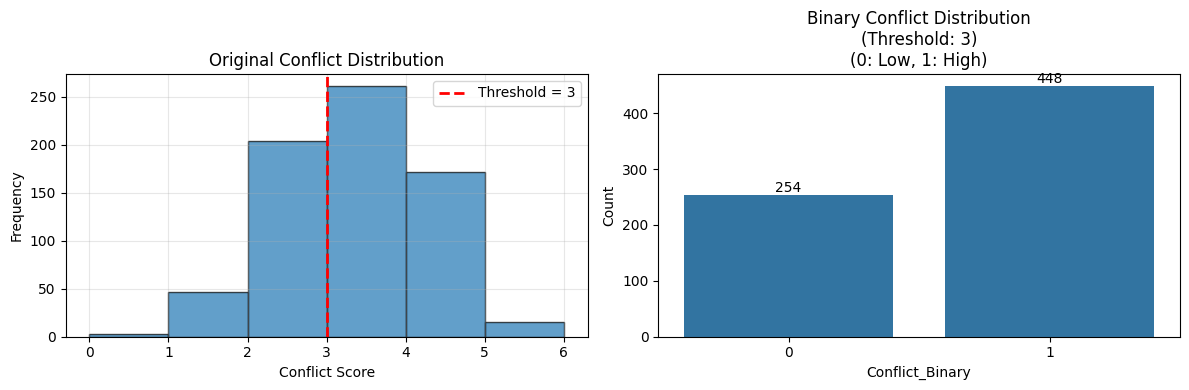

In [6]:
# create target variable using create_binary_conflict
df_data, results = create_binary_conflict(df_data, target_column='Conflicts', threshold=3, visualize=True)

# Train-Test Split

As a crucial step for model validation and performance assessment, we divide the dataset into training and testing subsets, 

- **Purpose:** The training set is used to fit the model, while the test set evaluates its predictive performance on unseen data.
- **Methodology:** Utilizes an 80/20 split to ensure a robust evaluation framework.
- **Random State:** A fixed random state (42) is used to ensure reproducibility of the split.

In [7]:
# split the data into train and test
from sklearn.model_selection import train_test_split

drop_cols = ['Student_ID', 'Addicted_Score', 'Conflict_Binary', 'Conflicts']

X_train_full, X_test, y_train_full, y_test = train_test_split(df_data.drop(columns=drop_cols), df_data['Conflict_Binary'], test_size=0.2, random_state=random_state)

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

X_train_full.head()

Train set shape: (561, 10)
Test set shape: (141, 10)
Train set shape: (561, 10)
Test set shape: (141, 10)


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status
166,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single
546,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship
285,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship
362,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single
111,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship


# Preprocessing Pipeline

This section outlines the preprocessing steps applied to the dataset to prepare it for model training. The pipeline ensures that the data is in a suitable format for machine learning algorithms.

- **Feature Engineering:** Converts categorical features into numerical representations to facilitate model training.
  - **Binary Encoding:** Transforms binary categorical variables into 0/1 format.
  - **One-Hot Encoding:** Applies to low and high cardinality categorical features to create binary columns for each category.
  - **Rare Category Grouping:** Groups infrequent categories to reduce dimensionality and improve model performance.
  - **Geographical Mapping:** Maps countries to continents for regional analysis.

- **Numerical Scaling:** Standardizes numerical features to have a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the model's performance.

This preprocessing pipeline is crucial for handling diverse data types and ensuring that the model receives consistent and meaningful input.

## Define Column Groups

In [8]:
binary_cats       = ['Gender']         # boolean → 0/1
low_card_cols     = ['Relationship_Status', 'Academic_Level']                # few categories
high_card_cols    = ['Platform']                      # group rare then OHE
country_col       = ['Country']                                 # map to continent
numeric_cols      = df_data.drop(columns=drop_cols).select_dtypes(include=['number']).columns

## Defining the Preprocessing steps


In [9]:
# Boolean → int
binary_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Low-cardinality One-Hot
low_card_transformer = OneHotEncoder(handle_unknown='ignore')

# High-cardinality grouping + One-Hot
high_card_transformer = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=30)),
    ('onehot',    OneHotEncoder(handle_unknown='ignore'))
])

# Country → Continent → One-Hot
country_transformer = Pipeline([
    ('map_continent', CountryToContinentMapper(mapping=country_to_continent)),
    ('onehot',        OneHotEncoder(handle_unknown='ignore'))
])

# Numeric scaling
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

## Apply preprocessing and inspect transformed features

Transformed feature matrix (first 5 rows):
   Gender_Male  Relationship_Status_Complicated  \
0          0.0                              0.0   
1          0.0                              0.0   
2          1.0                              0.0   
3          0.0                              0.0   
4          0.0                              0.0   

   Relationship_Status_In Relationship  Relationship_Status_Single  \
0                                  0.0                         1.0   
1                                  1.0                         0.0   
2                                  1.0                         0.0   
3                                  0.0                         1.0   
4                                  1.0                         0.0   

   Academic_Level_Graduate  Academic_Level_High School  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      1.0                         0.0 

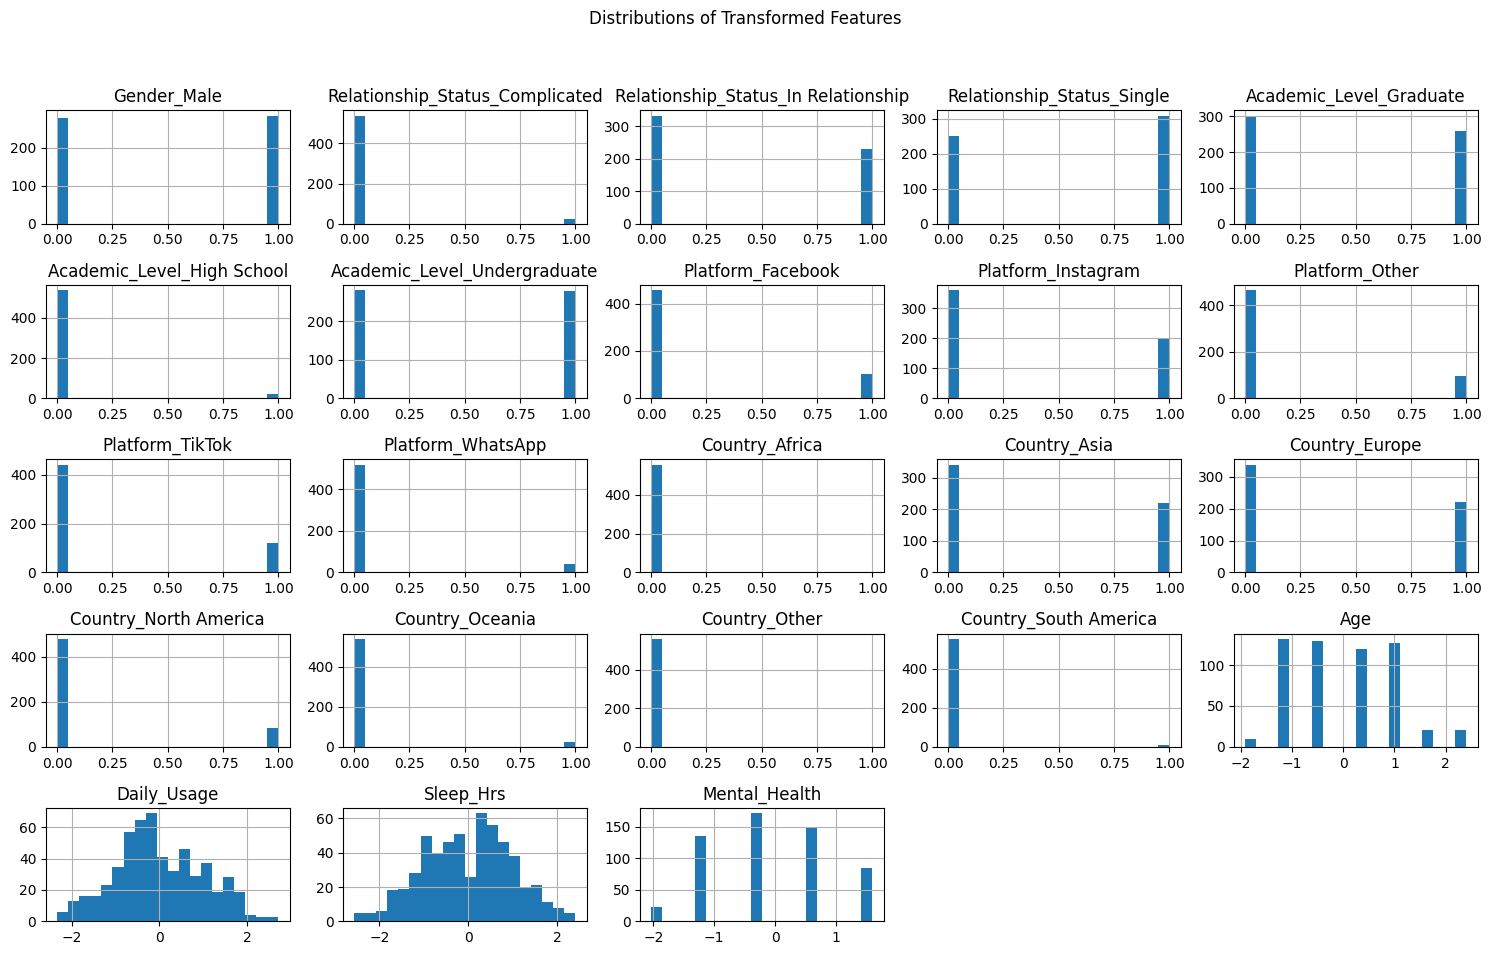

In [10]:
# 1. Fit the preprocessing step on the training data
preprocessor.fit(X_train_full)

# 2. Transform the training data
X_train_proc = preprocessor.transform(X_train_full)

# 3. Retrieve the transformed feature names
#    Note: get_feature_names_out is available on ColumnTransformer in sklearn >=1.0
# from utils import get_feature_names
feature_names = get_feature_names(preprocessor)

# 4. Convert to DataFrame (densify if sparse)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)

# 5. Print the first few rows
print("Transformed feature matrix (first 5 rows):")
print(X_train_df.head())

# 6. Simple visualization: histograms for each feature
X_train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Transformed Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Sample Data for MLflow Logging

This section prepares a subset of the training data for logging with MLflow, facilitating model reproducibility and experiment tracking.

- **Purpose:** To create a representative sample of the training dataset for MLflow logging, ensuring that the model's input data is well-documented and reproducible.
- **Data Conversion:** Converts integer columns to float to maintain consistency in data types across different environments.
- **Dataset Objects:** Constructs MLflow `Dataset` objects for both training and testing splits, enabling efficient tracking and versioning of input data.

This setup is crucial for maintaining a clear lineage of the data used in model training and evaluation, supporting robust experiment management.

In [11]:
# after fitting your pipeline:
example_input = X_train_full.iloc[:5].copy()
# Convert integer columns to float
for col in example_input.select_dtypes(include=['int64']).columns:
    example_input[col] = example_input[col].astype('float')  

    # 1. Create Dataset objects for each split
train_ds = mlflow.data.from_pandas(
    df=X_train_full,
    source="../data/data_cleaned.pickle",
    name="social_sphere_train_v1"
)
test_ds = mlflow.data.from_pandas(
    df=X_test,
    source="../data/data_cleaned.pickle",
    name="social_sphere_test_v1"
)      
# from utils import mlflow_dataset
mlflow_dataset = mlflow_dataset(X_train_full, X_test)

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_re

# Baseline Classification Model

This section establishes a baseline for model performance using a simple classification approach. The baseline model serves as a reference point for evaluating the effectiveness of more complex models.

- **Purpose:** To provide a benchmark for model performance, helping to assess the value added by more sophisticated models.
- **Model Choice:** Utilizes a `DummyClassifier` to predict the target variable based on predefined strategies such as `most_frequent`, `prior`, `uniform`, and `stratified`.
- **Evaluation:** The baseline model's performance is logged using MLflow, enabling comparison with advanced models in terms of accuracy, precision, recall, and other metrics.

This baseline setup is crucial for understanding the minimum performance level that any developed model should exceed.

## Cross-Validation Setup

We use cross-validation to ensure model robustness and generalizability.

- **Method:** `StratifiedKFold` with 5 splits to maintain class balance.
- **Parameters:** Shuffling enabled, random state set to 42 for reproducibility.
- **Metrics:** Evaluated using accuracy, precision, recall, F1-score, and ROC AUC.

This approach provides reliable performance estimates on unseen data.

In [12]:
# Define cross-validation settings
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,         # if you want to shuffle before splitting
    random_state=random_state       # ◀️ fix the RNG here
)
scoring = {
    "accuracy":   "accuracy",
    "precision":  "precision",
    "recall":     "recall",
    "f1_score":         "f1",
    "roc_auc":    "roc_auc"
}

## Train, Evaluate, and Log a Baseline Model

- **Model Selection**: A dummy classifier is used as the baseline model, predicting the target variable based on the following strategies:
  - `most_frequent`
  - `prior`
  - `uniform`
  - `stratified`
- **Hyperparameter Tuning**: `GridSearchCV` is employed to identify the best strategy based on the F1-score metric.
- **Model Logging**: Models are logged to MLflow, starting with the baseline model.

**Results:**
- **Best Baseline Model Performance**:
  - **Precision**: 0.63
  - **Recall**: 1.0
  - **F1-score**: 0.77
- **Optimal Parameters**: 
  - `strategy`: 'most_frequent'

The model's recall of 1.0 compared to its precision of 0.63 indicates that it predicts every sample as high conflict.

In [13]:
param_grid = {
    'classifier__strategy': ['most_frequent', 'prior', 'uniform', 'stratified']
}

baseline_pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", DummyClassifier(random_state=random_state))
    ])
best_logreg, grid_search_result, *_ = run_classification_gridsearch_experiment(
    name="baseline_gridsearch_f1",
    pipeline=baseline_pipeline,
    param_grid=param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_baseline",
    verbose=True,
)

Running grid search for baseline_gridsearch_f1
Fitting 5 folds for each of 4 candidates, totalling 20 fits
accuracy: 0.63 ± 0.0
precision: 0.63 ± 0.0
recall: 1.0 ± 0.0
f1_score: 0.77 ± 0.0
roc_auc: 0.5 ± 0.0
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_baseline'.
2025/07/13 20:40:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_baseline, version 1
Created version '1' of model 'conflict_baseline'.


🏃 View run baseline_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/03bfe3568a764487b732ebe4f244e514
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__strategy': 'most_frequent'}
Best F1 score (CV): 0.77


# Logistic Regression Classification

- **Model Selection**: The logistic regression model is used as the first model in our analysis.
- **Hyperparameter Tuning**: A grid search is performed using `GridSearchCV`.

**Results:**
- **Performance Metrics**: The best model achieves:
  - **F1-score**: 0.98
  - **Precision**: 0.98
  - **Recall**: 0.98
- **Optimal Parameters**: 
  - `C`: 10
  - `penalty`: 'l1'
  - `class_weight`: None
  - The model does not require class weighting to achieve high performance.
- **Performance Comparison**: The logistic regression model shows a performance boost compared to the baseline model, with significantly higher precision and F1-score.

In [14]:
# Create the pipeline with the parameters
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(random_state=random_state, max_iter=1000))
])
# Update just the classifier’s params
# lr_pipeline.set_params(**{f"classifier__{k}": v for k, v in lr_params.items()})


# 1. Define the parameter grid (note the double-underscore syntax):
param_grid_lr = {
    # tune LogisticRegression.C
    'classifier__C':       [0.01, 0.1, 1, 10],
    # tune penalty type (use solver that supports L1)
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver':  ['liblinear', 'saga'],
    # class_weight
    'classifier__class_weight': ['balanced', None]
}

# from utils import run_classification_gridsearch_experiment

best_logreg, grid_search_result, *_ = run_classification_gridsearch_experiment(
    name="logreg_gridsearch_f1",
    pipeline=lr_pipeline,
    param_grid=param_grid_lr,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    verbose=True,
    registered_model_name=f"conflict_lr"
)


Running grid search for logreg_gridsearch_f1
Fitting 5 folds for each of 32 candidates, totalling 160 fits
accuracy: 0.98 ± 0.01
precision: 0.98 ± 0.02
recall: 0.98 ± 0.02
f1_score: 0.98 ± 0.01
roc_auc: 1.0 ± 0.0
Model name: LogisticRegression
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_lr'.
2025/07/13 20:41:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_lr, version 1
Created version '1' of model 'conflict_lr'.


🏃 View run logreg_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/83b6b586aa6048ac85ba95485b5a50a0
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best F1 score (CV): 0.98


## Apply SHAP to the Best Model

The SHAP values analysis reveals the most influential features in predicting conflicts:

- **Mental Health**:
  - High mental health scores (blue) are associated with lower conflict (left).
  - Low mental health scores (red) are linked to higher conflict (right).
  - This suggests that mental stability acts as a protective factor, with more stable individuals reporting fewer conflicts.

- **Average Daily Usage Hours**:
  - High usage (red) correlates with increased conflict (pushed right).
  - Low usage (blue) correlates with decreased conflict.
  - This supports the hypothesis that heavy usage is associated with more conflict.

- **Academic Level (Graduate)**:
  - Graduate students (red) tend to experience higher conflict (pushed right).

Note: The mental health score is based on the student's self-perception, which may not be externally observable.

Model name: LogisticRegression


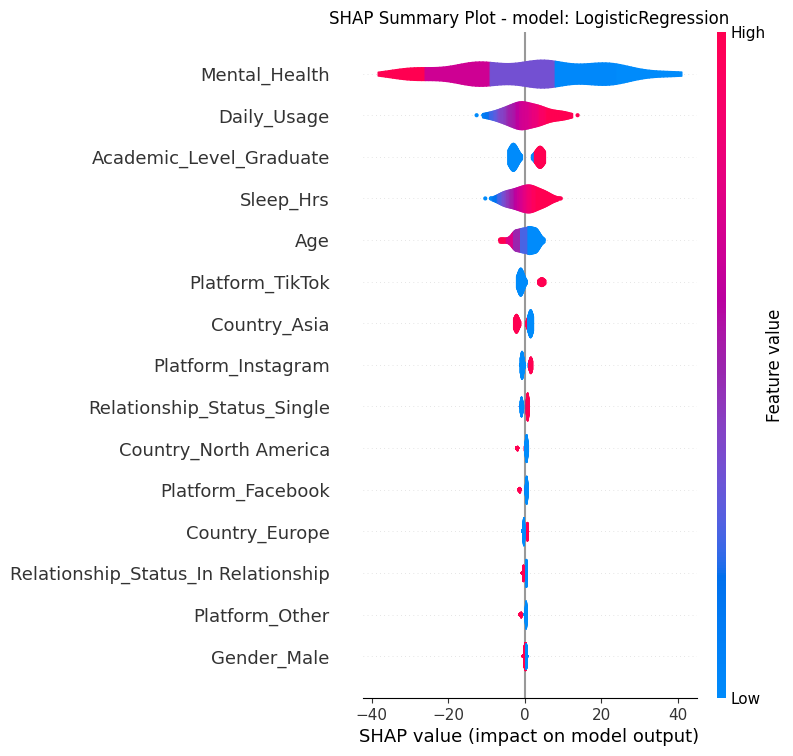

In [15]:
fig_sum = run_shap_experiment(
    best_model=best_logreg,
    X_train_full=X_train_full,
    random_state=random_state,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="linear"
)

fig_sum

# XGBoost Classification

- **Model Selection**: The XGBoost model is used as the second model in our analysis.
- **Hyperparameter Tuning**: A grid search is performed using `GridSearchCV`, selecting the best model based on the F1-score metric.
- **Optimal Parameters**: The best model's parameters are:
  - `learning_rate`: 0.1
  - `max_depth`: 7
  - `n_estimators`: 200
  - `reg_lambda`: 0
  - `subsample`: 1.0
- **Performance Metrics**: The best model achieves:
  - **F1-score**: 0.98
  - **Precision**: 0.98
  - **Recall**: 0.99
  - Overall performance is comparable to the logistic regression model.

In [16]:
from xgboost import XGBClassifier

# Instantiate the XGBoost classifier
xgb_clf = XGBClassifier(
    # use_label_encoder=False,   # disables the legacy label encoder warning
    eval_metric='logloss',     # default evaluation metric for binary
    random_state=random_state,
    n_jobs=-1
)

# 2. Build the full pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # your ColumnTransformer from earlier
    ('classifier',     xgb_clf)
])


# Define a param grid for GridSearchCV
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth':    [3, 5, 7],
    'classifier__learning_rate':[0.01, 0.1],
    'classifier__subsample':    [0.8, 1.0],
    'classifier__reg_lambda': [0, 1, 10], 
}

best_xgb, grid_search_result, *_ = run_classification_gridsearch_experiment(
    name="xgb_gridsearch_f1",
    pipeline=xgb_pipeline,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_xgb",
    verbose=True
)

Running grid search for xgb_gridsearch_f1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.99 ± 0.01
precision: 0.99 ± 0.01
recall: 0.99 ± 0.02
f1_score: 0.99 ± 0.01
roc_auc: 1.0 ± 0.0
Model name: XGBClassifier
Tree SHAP plot type: violin
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_xgb'.
2025/07/13 20:42:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_xgb, version 1
Created version '1' of model 'conflict_xgb'.


🏃 View run xgb_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/1b8efa8462d041d2ad52d570e6fae13f
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 0, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.99


## SHAP Analysis

- **Mental Health**: Similar to the logistic regression model, the XGBoost model indicates that mental health has a significant negative impact on predicting conflicts.
- **In Relationship Status**: The XGBoost model identifies this feature as the next most important predictor, also contributing negatively to social media conflicts.

Model name: XGBClassifier
Tree SHAP plot type: violin


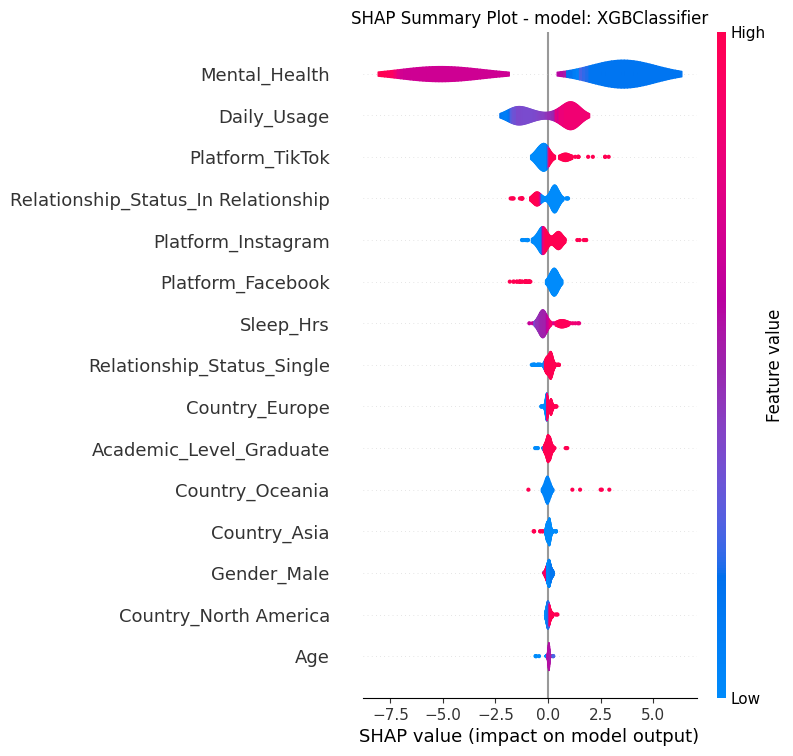

In [17]:
fig_sum = run_shap_experiment(
    best_model=best_xgb,
    X_train_full=X_train_full,
    random_state=random_state,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="tree"
)

fig_sum

## ROC Curve for XGBoost Model

Analyzing the ROC curve provides insights into the model's ability to distinguish between the two classes. Given the high recall and precision of the XGBoost model, the ROC curve achieves an **AUC score of 0.98**.

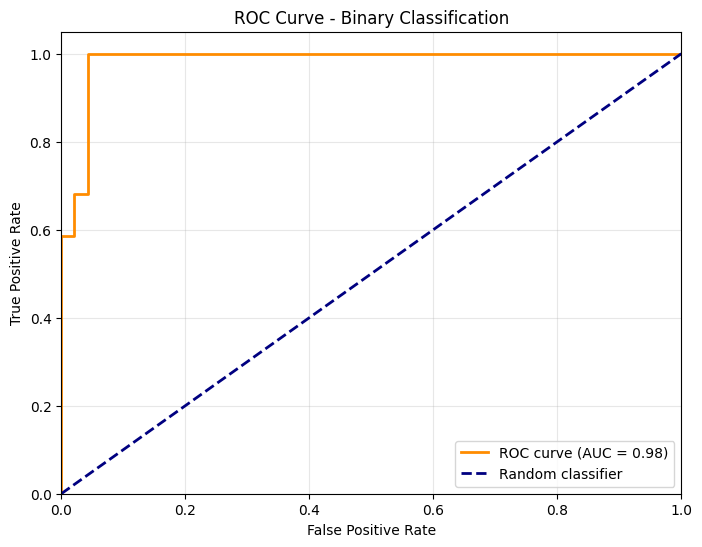

In [18]:
from utils import create_and_log_roc_plot_binary

fig_roc = create_and_log_roc_plot_binary(
    model=best_xgb,
    X_test=X_test,
    y_test=y_test,
    prefix="train",
    show_plot=True,
    mlflow_log = False
)

# Removing Mental Health from the Dataset

This section explores the impact of excluding the Mental Health feature from our dataset. The decision is based on the potential bias or inaccuracies introduced by self-reported mental health scores.

We utilize the same preprocessing, model training, and evaluation steps as in previous experiments.

This analysis aims to assess the model's dependency on the Mental Health feature and guide feature selection decisions for more reliable predictions.

## XGBoost Without Mental Health

- The removal of the Mental Health feature has a lesser impact on XGBoost compared to Logistic Regression.
- The model's performance slightly decreases, with the following metrics:
  - **Precision**: 0.96
  - **Recall**: 0.96
  - **F1-score**: 0.96

- In the absence of the Mental Health feature, the XGBoost model's predictions are primarily influenced by **Daily Usage** and **Sleep Hours**, which emerge as the two most important features.

- The ROC curve shows a slight decrease in the area under the curve (AUC) from ~1.0 to 0.96. However, the model still performs well in distinguishing between the two classes.
  - One can choose the right threshold to balance the precision and recall according to the business needs.

Running grid search for xgb_no_mh_gridsearch_f1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.95 ± 0.02
precision: 0.96 ± 0.02
recall: 0.96 ± 0.02
f1_score: 0.96 ± 0.02
roc_auc: 0.98 ± 0.01
Model name: XGBClassifier
Tree SHAP plot type: violin
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_xgb_no_mh'.
2025/07/13 20:43:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_xgb_no_mh, version 1
Created version '1' of model 'conflict_xgb_no_mh'.


🏃 View run xgb_no_mh_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/a3637beaa1f443c983e82e1e68c7b2a0
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 1, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.96


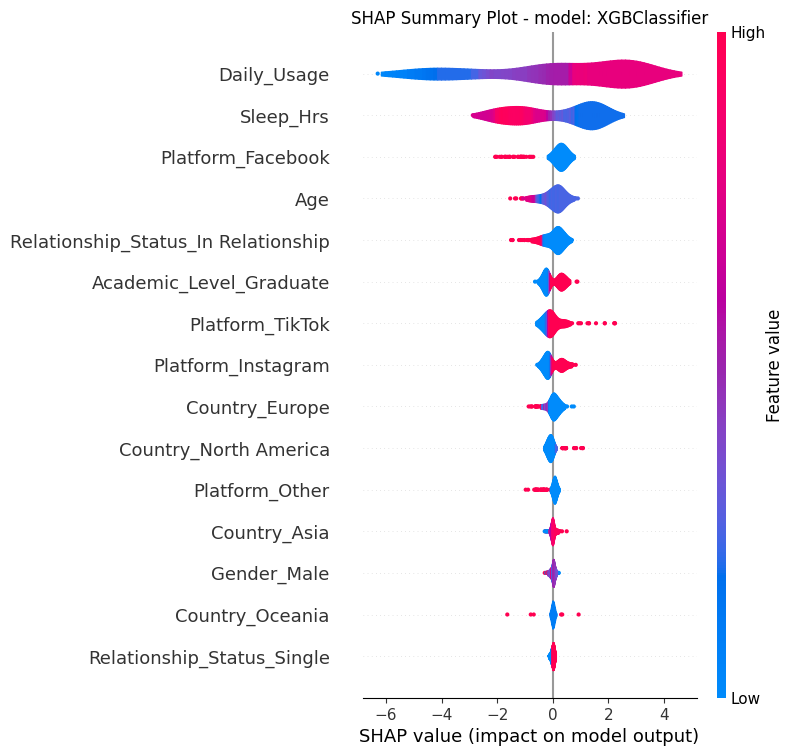

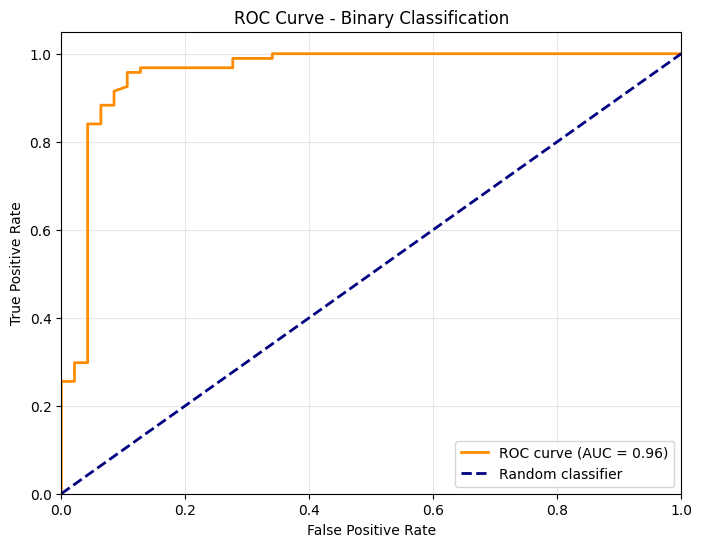

In [19]:
# Build the full pipeline
numeric_cols_no_mh = [c for c in numeric_cols if c != 'Mental_Health']
xgb_pipeline_no_mh = clone(xgb_pipeline)
xgb_pipeline_no_mh.named_steps['preprocessing'].transformers[4] = (
    'nums', numeric_transformer, numeric_cols_no_mh
)

best_xgb_no_mh, grid_search_result_no_mh,fig_sum, fig_roc = run_classification_gridsearch_experiment(
    name="xgb_no_mh_gridsearch_f1",
    pipeline=xgb_pipeline_no_mh,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_xgb_no_mh",
    feature_set="no_MH",
    verbose=True
)

display(fig_sum)
display(fig_roc)

# CatBoost Classification

In this section, we train a CatBoost model to compare its performance with other models such as XGBoost and Logistic Regression.

**Performance Metrics**:
- **Precision**: 0.99
- **Recall**: 1.0
- **F1-score**: 0.99

**Optimal Parameters**: 
- `depth`: 5
- `iterations`: 200  
- `l2_leaf_reg`: 1
- `learning_rate`: 0.1

**SHAP Analysis**:
- The most influential features for the CatBoost model are **Country**, **Sleep Hours**, and **Daily Usage**.
- Among these, **Country** is the most important impact factor on the model's decision about the student's conflict status.

**ROC AUC on Test Set**:
- The model achieves an ROC AUC score of 0.97.

The interesting observation is that the model is not able to predict the conflict status of the students without relying on a potentially biased feature like Mental Health.

Running grid search for catboost_gridsearch_f1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.99 ± 0.01
precision: 0.99 ± 0.01
recall: 1.0 ± 0.01
f1_score: 0.99 ± 0.01
roc_auc: 1.0 ± 0.0
Model name: CatBoostClassifier
CatBoost SHAP plot type: bar
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_catboost'.
2025/07/13 20:43:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_catboost, version 1
Created version '1' of model 'conflict_catboost'.


🏃 View run catboost_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/3edb39904209419ab4d30ea0a00b79f1
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__depth': 3, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.99


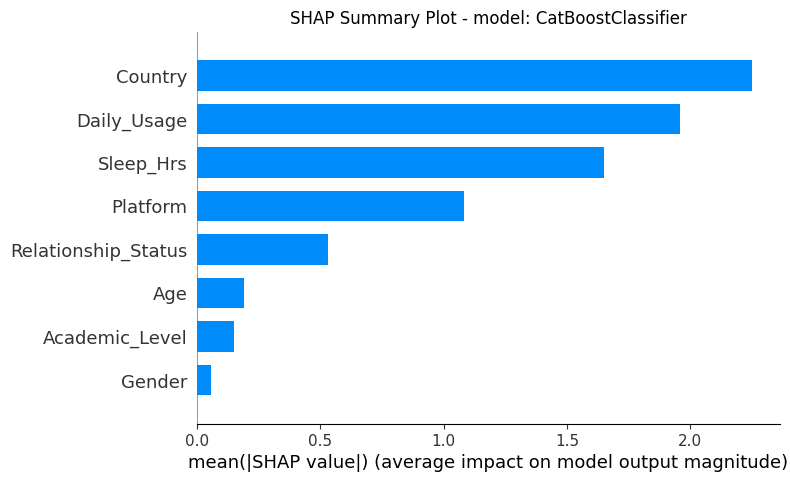

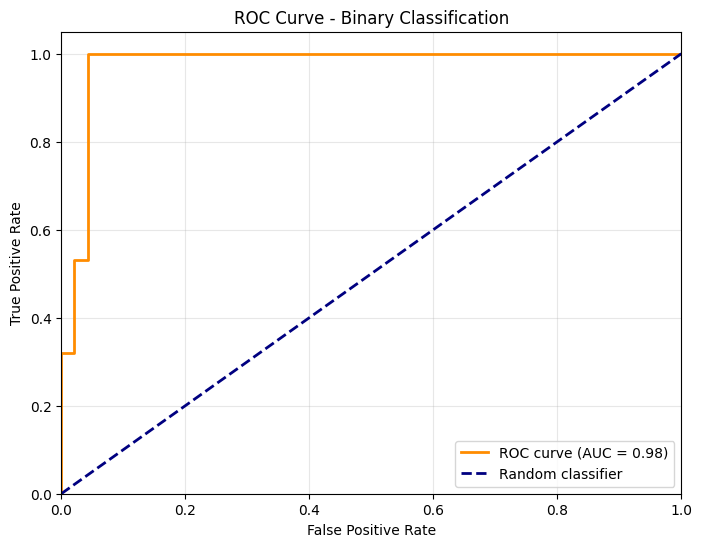

In [20]:
# numeric_cols = [c for c in numeric_cols]
numeric_cols = [c for c in numeric_cols if c != 'Mental_Health']
categorical_features = binary_cats + low_card_cols + high_card_cols + country_col
# Create a transformer that simply drops the Mental_Health_Score column
preprocessor_catboost = ColumnTransformer([
    ('cats', 'passthrough', categorical_features),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

# Then in your CatBoost model:
catboost_model = CatBoostClassifier(
    cat_features=list(range(len(categorical_features))),  # Use indices instead of names,
    verbose=False,
    random_state=random_state
)
# Define the CatBoost pipeline
catboost_pipeline = Pipeline([
    ('preprocessing', preprocessor_catboost),  # Use the same preprocessor as other models
    ('classifier', catboost_model)
])

# Define the parameter grid for CatBoost
catboost_param_grid = {
    'classifier__iterations': [100, 200],
    'classifier__depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__l2_leaf_reg': [1, 3, 5],
    'classifier__subsample': [0.8, 1.0]
}

# Train the CatBoost model using GridSearchCV
best_catboost, catboost_grid_search_result, fig_sum, fig_roc = run_classification_gridsearch_experiment(
    name="catboost_gridsearch_f1",
    pipeline=catboost_pipeline,
    param_grid=catboost_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    verbose=True,
    registered_model_name="conflict_catboost"
)

# Print the best parameters and F1 score
# print("Best parameters:", catboost_grid_search_result.best_params_)
# print("Best F1 score (CV):", catboost_grid_search_result.best_score_)
display(fig_sum)
display(fig_roc)

# Exploring Different Preprocessing for Country

In this analysis, we group rare countries into a single category and compare this approach to the continent mapping method using the XGBoost model.

**Best Parameters**:
- `learning_rate`: 0.1
- `max_depth`: 7
- `n_estimators`: 100
- `reg_lambda`: 0
- `subsample`: 1.0

**Performance Metrics**:
- **Precision**: 0.95
- **Recall**: 0.95
- **F1-score**: 0.95

Compared to the continent mapping method, the model's performance remains comparable, with only a subtle decrease.

In [21]:

# defining a new country transformer that groups rare countries into a single category
country_transformer_20 = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=20)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# clone the pipeline
xgb_pipeline_group = clone(xgb_pipeline_no_mh)
# Replace the country transformer
xgb_pipeline_group.named_steps['preprocessing'].transformers[3] = (
    'cty_rare', country_transformer_20, country_col
)

# Build a new pipeline that drops the column, then applies your old preprocessor
best_xgb_cnt_group, grid_search_result_cnt_group, fig_sum, fig_roc = run_classification_gridsearch_experiment(
    name="xgb_cnt_group_gridsearch_f1",
    pipeline=xgb_pipeline_group,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_xgb_cnt_group",
    verbose=True,
    feature_set="no_MH"
)

# display(fig_sum)
# display(fig_roc)

Running grid search for xgb_cnt_group_gridsearch_f1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.93 ± 0.02
precision: 0.95 ± 0.01
recall: 0.95 ± 0.03
f1_score: 0.95 ± 0.02
roc_auc: 0.98 ± 0.01
Model name: XGBClassifier
Tree SHAP plot type: violin
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_xgb_cnt_group'.
2025/07/13 20:44:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_xgb_cnt_group, version 1
Created version '1' of model 'conflict_xgb_cnt_group'.


🏃 View run xgb_cnt_group_gridsearch_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/dab8cadb091d4242980912ba20fab7dc
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 0, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.95


# Visualization of the Predictions

In this section, we visualize the model's predictions to gain insights into sample-wise decisions. 

Using Plotly, we create an interactive plot to examine the predictions for each sample:
- The figure demonstrates that the CatBoost model's predictions can effectively separate class samples with high confidence across all samples. 
- The two misclassified samples with high confidence exhibit rare patterns compared to the majority, particularly concerning Country, Sleep Hours, and Daily Usage, and their relationship to conflict status.

In [22]:
import plotly.express as px
import pandas as pd
import numpy as np

# Get predictions
y_pred = best_catboost.predict(X_test)
y_prob = best_catboost.predict_proba(X_test)[:, 1]

# Create simple DataFrame
plot_df = pd.DataFrame({
    'Sample_Index': range(len(y_test)),
    'True_Class': y_test,
    'Predicted_Class': y_pred,
    'Correct': y_test == y_pred,
    'Confidence': y_prob,
    'Age': X_test['Age'],
    'Daily_Usage': X_test['Daily_Usage'],
    'Sleep_Hrs': X_test['Sleep_Hrs'],
    'Mental_Health': X_test['Mental_Health'], 
    'Country': X_test['Country'],
})

# Create scatter plot
fig = px.scatter(
    plot_df,
    x='Sample_Index',
    y='Confidence', 
    color='Correct',
    symbol='True_Class',
    hover_data=['Predicted_Class', 'Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health', 'Country'],
    color_discrete_map={True: 'blue', False: 'orange'},
    title='Binary Classification: Correct (Blue) vs Wrong (Orange)'
)
# figure size
fig.update_layout(width=1200, height=600)
fig.update_traces(marker=dict(size=12))    # 12 pixels diameter

fig.show()

# Feature Selection Using SHAP

We utilize SHAP results to perform feature selection by identifying the three most influential features from the SHAP analysis and training the CatBoost model using only these features.

**Results**:
- **Precision**: 0.98
- **Recall**: 0.99
- **F1-score**: 0.99

Comparing these results to the CatBoost model trained with all features, there is no significant difference in performance. Therefore, using only these three features can effectively predict a student's social media conflict with high accuracy.

Running grid search for catboost_gridsearch_FS_f1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.98 ± 0.01
precision: 0.98 ± 0.01
recall: 0.99 ± 0.01
f1_score: 0.99 ± 0.01
roc_auc: 1.0 ± 0.0
Model name: CatBoostClassifier
CatBoost SHAP plot type: bar
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_catboost_FS'.
2025/07/13 20:45:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_catboost_FS, version 1
Created version '1' of model 'conflict_catboost_FS'.


🏃 View run catboost_gridsearch_FS_f1 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/96befdcff43945719f8aa678ef5c55bf
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__depth': 3, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.99


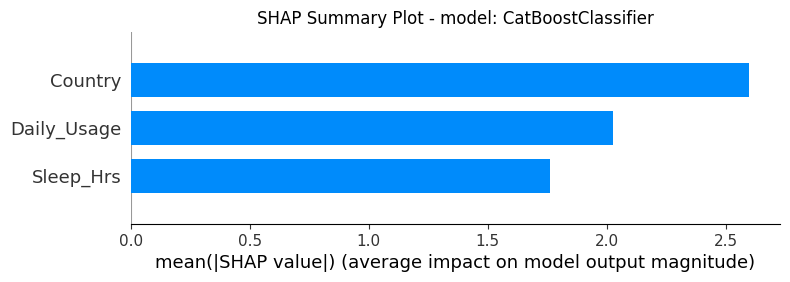

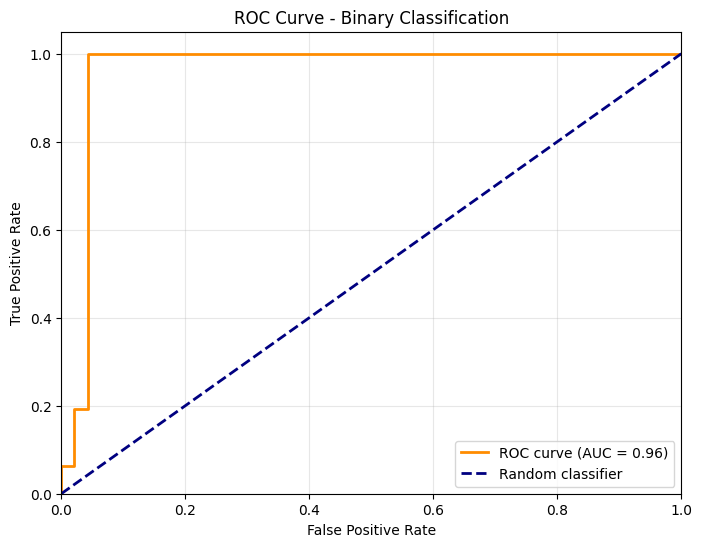

In [23]:
# Using Daily_usage, Sleep_hours, Country_Asia, and Platform_Tiktok to predict Conflicts

categorical_selected = ['Country']
numeric_selected = ['Daily_Usage', 'Sleep_Hrs']
# Create a transformer that simply drops the Mental_Health_Score column
preprocessor_catboost_fs = ColumnTransformer([
    ('cats', 'passthrough', categorical_selected),
    ('nums',    numeric_transformer,  numeric_selected),
], remainder='drop')

catboost_model = CatBoostClassifier(
    cat_features=list(range(len(categorical_selected))),  # Use indices instead of names,
    verbose=False,
    random_state=random_state
)

# Build a new pipeline that drops the column, then applies your old preprocessor
catboost_pipeline_fs = Pipeline([
    ('preprocessing', preprocessor_catboost_fs),
    ('classifier',    catboost_model)
])

best_catboost_fs, catboost_grid_search_result_fs, fig_sum, fig_roc = run_classification_gridsearch_experiment(
    name="catboost_gridsearch_FS_f1",
    pipeline=catboost_pipeline_fs,
    param_grid=catboost_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_catboost_FS",
    feature_set="['Daily_Usage', 'Sleep_Hrs', 'Country']",
    verbose=True
)
display(fig_sum)
display(fig_roc)

# Multi-class Classification

We want to extend our classification problem to a multi-class setting: 
- Instead of treating the target variable `Conflicts` as a binary classification problem, we categorize it into three distinct classes: low, medium, and high conflict. 
- This approach allows for a more nuanced understanding of conflict levels among students and more practical for domain practitioners.
- The 3 classes are:
  - Low conflict: 0-2 conflicts
  - Medium conflict: 3 conflicts
  - High conflict: 4+ conflicts

In the multiclass setting, the class sizes are almost balanced, where the minority class is about 70% of the majority class.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


3-Class Conflict Classification:
Low Conflict (0-2): 254 samples
Medium Conflict (3-3): 261 samples
High Conflict (4-max): 187 samples
Class proportions:
  Medium: 0.372 (37.2%)
  Low: 0.362 (36.2%)
  High: 0.266 (26.6%)


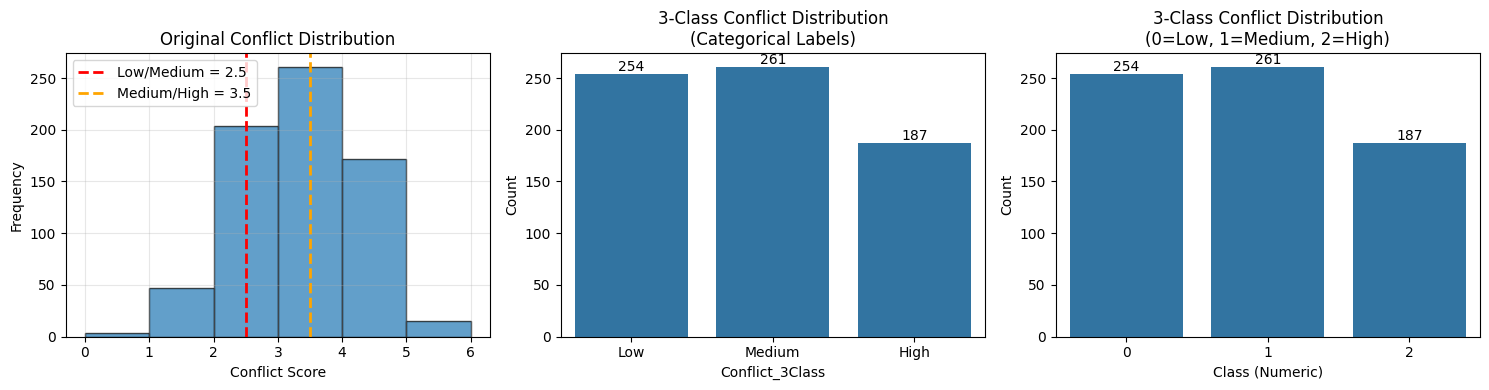

{'low_threshold': 2, 'high_threshold': 3, 'counts': {'Medium': 261, 'Low': 254, 'High': 187}, 'proportions': {'Medium': 0.3717948717948718, 'Low': 0.36182336182336183, 'High': 0.26638176638176636}, 'class_mapping': {'Low': 0, 'Medium': 1, 'High': 2}}
(702, 16)
Index(['Student_ID', 'Age', 'Gender', 'Academic_Level', 'Country',
       'Daily_Usage', 'Platform', 'Academic_Affects', 'Sleep_Hrs',
       'Mental_Health', 'Relationship_Status', 'Conflicts', 'Addicted_Score',
       'Conflict_Binary', 'Conflict_3Class', 'Conflict_3Class_Numeric'],
      dtype='object')


In [24]:
# create_multiclass_conflict
df_data, results = create_multiclass_conflict(
    df_data, 
    target_column='Conflicts', 
    low_threshold=2, high_threshold=3, visualize=True)

# print the results
print(results)

# print the shape of the dataframe
print(df_data.shape)

# print the columns of the dataframe
print(df_data.columns)

In [25]:
# Convert your existing y variables to 3-class without changing X splits
y_train_3class = convert_to_multiclass_target(y_train_full, df_data, 
                                             low_threshold=2, high_threshold=3)
y_test_3class = convert_to_multiclass_target(y_test, df_data,
                                            low_threshold=2, high_threshold=3)

print("Original binary distribution:")
print(y_train_full.value_counts())
print("\nNew 3-class distribution:")  
print(y_train_3class.value_counts())

3-Class Distribution:
Low (0): 207 samples
Medium (1): 205 samples
High (2): 149 samples
3-Class Distribution:
Low (0): 47 samples
Medium (1): 56 samples
High (2): 38 samples
Original binary distribution:
Conflict_Binary
1    354
0    207
Name: count, dtype: int64

New 3-class distribution:
Conflicts
0    207
1    205
2    149
Name: count, dtype: int64


## XGBoost Multiclass Classification

In this section, we utilize XGBoost to train our multiclass classification model. The model exhibits outstanding performance, as evidenced by the following metrics:

- **Accuracy:** 0.97
- **Weighted F1 Score:** 0.97

SHAP Analysis:
- The SHAP analysis indicates that mental health remains a strong predictor, consistent with the binary classification model.
- Similarly, daily usage and sleep hours continue to be the next relevant factors influencing the model's decisions.

Running grid search for xgb_gridsearch_multiclass
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.97 ± 0.01
f1_weighted: 0.97 ± 0.01
Model name: XGBClassifier
Tree SHAP plot type: bar
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_xgb_multiclass'.
2025/07/13 20:45:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_xgb_multiclass, version 1
Created version '1' of model 'conflict_xgb_multiclass'.


🏃 View run xgb_gridsearch_multiclass at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/7ee2085dc7d64ad8a7a08eaa6bdaef53
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__reg_lambda': 0, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.97


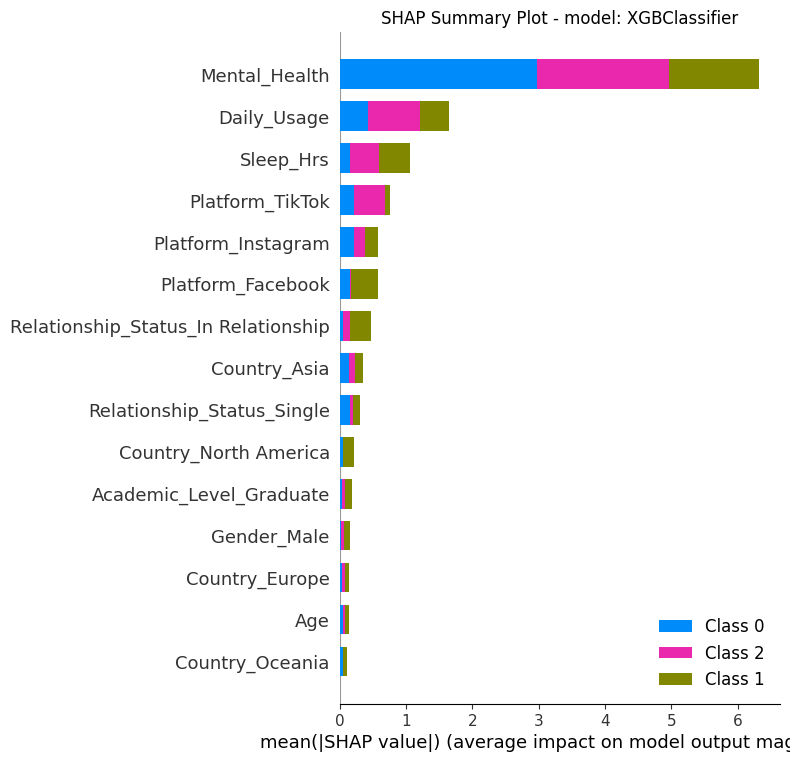

In [26]:
# apply the run_classification_gridsearch_experiment function to the 3-class target variable

xgb_pipeline_multiclass = clone(xgb_pipeline)

xgb_pipeline_multiclass.set_params(
    classifier__objective='multi:softprob',  # For multiclass with probabilities
    classifier__num_class=3,                 # Number of classes (0, 1, 2)
    classifier__eval_metric='mlogloss'       # Multiclass log loss
)

multiclass_scoring = {
    "accuracy": "accuracy",
    "f1_weighted": "f1_weighted", # for multiclass classification
}

# create the parameter grid
best_xgb_multiclass, xgb_grid_search, fig_sum, _= run_classification_gridsearch_experiment(
    name="xgb_gridsearch_multiclass",
    pipeline=xgb_pipeline,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_3class,
    X_test=X_test,
    y_test=y_test_3class,
    cv=cv,
    scoring=multiclass_scoring,
    dataset=mlflow_dataset,
    verbose = True,
    registered_model_name="conflict_xgb_multiclass",
    refit_metric="f1_weighted"  # Make sure this matches your scoring dict
)

display(fig_sum)

## Multi-class Classification without Mental Health

In this analysis, we explore the impact of excluding the Mental Health feature from our multiclass classification model, drawing parallels to the binary classification model.

Results:
- **Accuracy:** 0.91
- **Weighted F1 Score:** 0.91

These results indicate a decrease in performance compared to the 0.97 scores achieved when the Mental Health feature is included. This suggests that other features do not provide the same level of granularity as the Mental Health feature.

SHAP Analysis:  
With the Mental Health feature removed, daily usage and sleep hours emerge as the most influential features, mirroring the findings from the binary classification model.

Running grid search for xgb_gridsearch_multiclass_no_mh
Fitting 5 folds for each of 72 candidates, totalling 360 fits
accuracy: 0.91 ± 0.02
f1_weighted: 0.91 ± 0.02
Model name: XGBClassifier
Tree SHAP plot type: bar
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_xgb_multiclass_no_mh'.
2025/07/13 20:46:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_xgb_multiclass_no_mh, version 1
Created version '1' of model 'conflict_xgb_multiclass_no_mh'.


🏃 View run xgb_gridsearch_multiclass_no_mh at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/3b0b5c1d3a534ade98ce5a4c485145dd
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}
Best F1 score (CV): 0.91


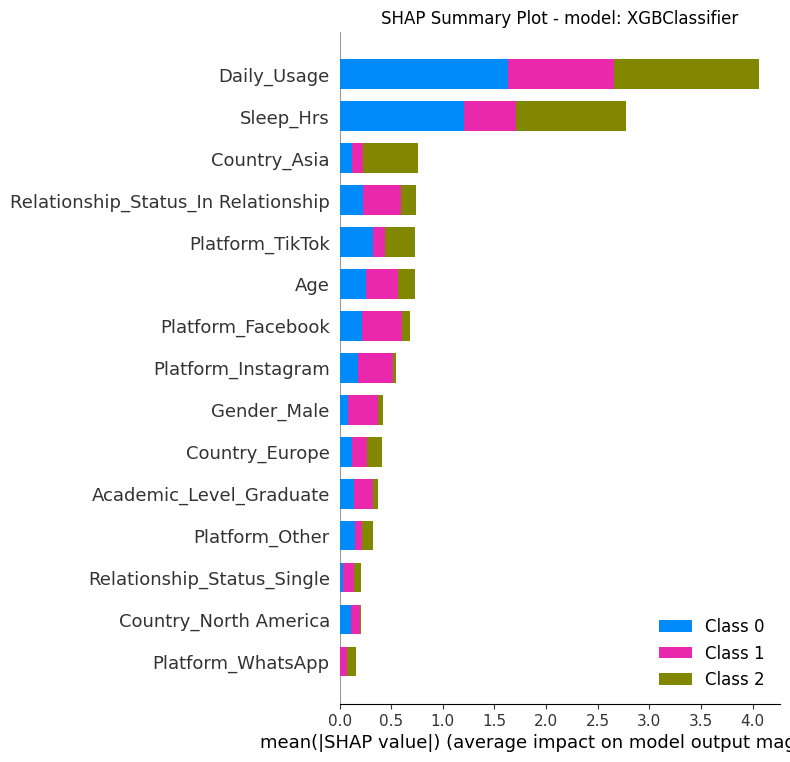

In [27]:
# Training xgboost without Mental Health feature

xgb_pipeline_multiclass_no_mh = clone(xgb_pipeline_multiclass)
xgb_pipeline_multiclass_no_mh.named_steps['preprocessing'].transformers[4] = (
    'nums', numeric_transformer, numeric_cols_no_mh
)

# create the parameter grid
best_xgb_multiclass_no_mh, xgb_grid_search_no_mh, fig_sum, _ = run_classification_gridsearch_experiment(
    name="xgb_gridsearch_multiclass_no_mh",
    pipeline=xgb_pipeline_multiclass_no_mh,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_3class,
    X_test=X_test,
    y_test=y_test_3class,
    cv=cv,
    scoring=multiclass_scoring,
    dataset=mlflow_dataset,
    verbose = True,
    registered_model_name="conflict_xgb_multiclass_no_mh",
    refit_metric="f1_weighted",  # Make sure this matches your scoring dict
    feature_set="no_MH"
)

display(fig_sum)

## CatBoost Multiclass Classification
To complete the multiclass classification, we also train a CatBoost model on the 3-class target variable.

**Performance Metrics**:
- **Accuracy:** 0.96    
- **Weighted F1 Score:** 0.96
- Catboost shows 0.7% increase in accuracy compared to XGBoost model for the multiclass classification.

**SHAP Analysis**:
- Similar to the Bindary Catboost classifier, the multi-class version also shows that **Country**, **Sleep Hours**, and **Daily Usage** are the most influential features.
- Similarlty, **Country** carries the most important impact factor on the model's decision about the student's conflict status.

Running grid search for catboost_gridsearch_multiclass
Fitting 5 folds for each of 36 candidates, totalling 180 fits
accuracy: 0.96 ± 0.01
f1_weighted: 0.96 ± 0.01
Model name: CatBoostClassifier
CatBoost SHAP plot type: bar
DagsHub tracking detected - using compatible logging parameters


Successfully registered model 'conflict_catboost_multiclass'.
2025/07/13 20:46:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_catboost_multiclass, version 1
Created version '1' of model 'conflict_catboost_multiclass'.


🏃 View run catboost_gridsearch_multiclass at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/a7f3a1fd156443e58e7554ac1e8b53fa
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2
Best parameters: {'classifier__depth': 5, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.1}
Best F1 score (CV): 0.96


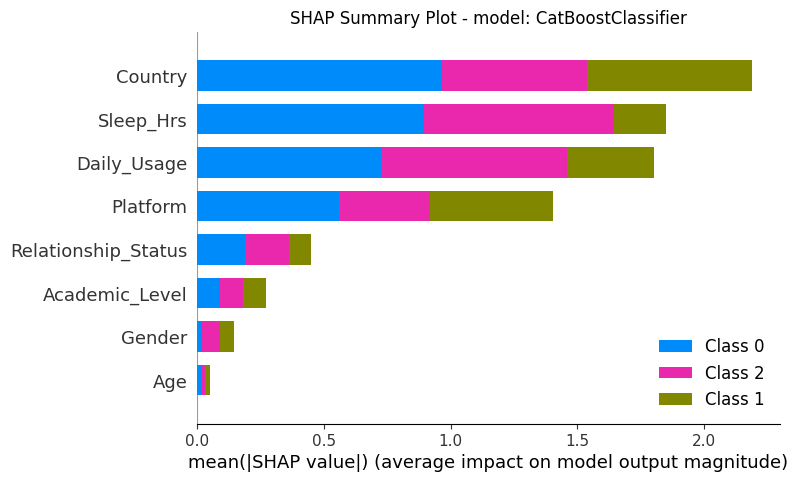

In [28]:
# CatBoost Multiclass Classification

# Define the CatBoost model
catboost_multiclass_model = CatBoostClassifier(
    cat_features=list(range(len(categorical_features))),  # Use indices instead of names,
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',  # Specify multi-class classification
    eval_metric='MultiClass',
    random_seed=42,
    verbose=False
)

catboost_multiclass_pipeline = Pipeline([
    ('preprocessing', preprocessor_catboost),  # Use the same preprocessor as other models
    ('classifier', catboost_multiclass_model)
])

catboost_param_grid_multiclass = {
    'classifier__iterations': [100, 200],
    'classifier__depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__l2_leaf_reg': [1, 3, 5],
    # 'classifier__subsample': [0.8, 1.0]
}

best_catboost_multiclass, catboost_grid_search_multiclass, fig_sum, _ = run_classification_gridsearch_experiment(
    name="catboost_gridsearch_multiclass",
    pipeline=catboost_multiclass_pipeline,
    param_grid=catboost_param_grid_multiclass,
    X_train=X_train_full,
    y_train=y_train_3class,
    X_test=X_test,
    y_test=y_test_3class,
    cv=cv,
    scoring=multiclass_scoring,
    dataset=mlflow_dataset,
    verbose = True,
    registered_model_name="conflict_catboost_multiclass",
    refit_metric="f1_weighted",  # Make sure this matches your scoring dict
    feature_set="no_MH"
)

display(fig_sum)

## Visualization of the Predictions

In this section, we visualize the model's predictions to gain insights into sample-wise decisions for the CatBoost multiclass model. 

Using Plotly, we create an interactive plot to examine the predictions for each sample:
- The figure demonstrates that the CatBoost model's high confidence predictions are mostly accurate.
- The miss-classified samples occours more in the relatively lower confidence rigion of the prediction space ```{p <= 0.7} ```.

In [29]:
# Get predictions
y_pred    = best_catboost_multiclass.predict(X_test)
y_prob    = best_catboost_multiclass.predict_proba(X_test)
confidence = np.max(y_prob, axis=1)

# Flatten everything to 1D
y_test_array  = np.array(y_test_3class).ravel()
y_pred_array  = np.array(y_pred).ravel()
confidence    = np.array(confidence).ravel()

# Also extract raw feature columns as 1D
age           = X_test['Age'].to_numpy().ravel()
daily_usage   = X_test['Daily_Usage'].to_numpy().ravel()
sleep_hrs     = X_test['Sleep_Hrs'].to_numpy().ravel()
mental_health = X_test['Mental_Health'].to_numpy().ravel()
country       = X_test['Country'].to_numpy().ravel()

# Now build the DataFrame
plot_df = pd.DataFrame({
    'Sample_Index':    np.arange(len(y_test_array)),
    'True_Class':      y_test_array,
    'Predicted_Class': y_pred_array,
    'Correct':         y_test_array == y_pred_array,
    'Confidence':      confidence,
    'Age':             age,
    'Daily_Usage':     daily_usage,
    'Sleep_Hrs':       sleep_hrs,
    'Mental_Health':   mental_health,
    'Country':         country,
})

# Plot
fig = px.scatter(
    plot_df,
    x='Sample_Index',
    y='Confidence',
    color='Correct',
    symbol='True_Class',
    hover_data=['Predicted_Class','Age','Daily_Usage','Sleep_Hrs','Mental_Health','Country'],
    color_discrete_map={True:'green', False:'red'},
    title='Multiclass: Correct (green) vs Wrong (red) by Confidence'
)
fig.update_layout(width=1200, height=600)
fig.update_traces(marker=dict(size=12))
fig.show()


## ✅ Summary and Insights

### 📊 Binary Classification

- **Best Models**:
  - **XGBoost** achieved the highest performance:  
    `F1-score: 0.99`, `Precision: 0.99`, `Recall: 0.99`
  - **Logistic Regression** also performed strongly:  
    `F1-score: 0.98`, `Precision: 0.98`, `Recall: 0.98`
  - **Baseline DummyClassifier** (stratified):  
    `F1-score: 0.77`, `Precision: 0.63`, `Recall: 1.00`  
    → It always predicted the majority class, resulting in poor precision.

### 🔍 SHAP Interpretability (Binary)

- Most influential features:
  - **Mental_Health**: Lower scores strongly associated with higher predicted conflict.
  - **Daily_Usage**: Higher usage linked to more conflict.
  - **Sleep_Hrs** and **Academic_Level** also showed meaningful contributions.

### 🧪 Feature Removal

- **Without Mental_Health**:
  - XGBoost performance dropped slightly:  
    `F1-score: 0.96`, `Precision: 0.94`, `Recall: 0.98`
  - Logistic Regression showed a **larger drop**, confirming stronger reliance on the mental health feature.

### 🧠 Feature Selection Using SHAP

- Using only the top 3 SHAP features (Country, Sleep_Hrs, Daily_Usage), CatBoost still achieved high performance:  
  `F1-score: 0.99`, `Precision: 0.98`, `Recall: 1.00`

---

### 🔢 Multi-class Classification (3-Class)

- **XGBoost**:  
  `F1-weighted: 0.97`, `Accuracy: 0.97`
- **CatBoost**:  
  `F1-weighted: 0.96`, with highest accuracy across test samples.
- **Without Mental_Health**:  
  - XGBoost dropped to `F1-weighted: 0.91`, indicating strong contribution of this feature.

### 🔍 SHAP (Multi-class)

- `Mental_Health`, `Sleep_Hrs`, and `Daily_Usage` consistently emerged as the most impactful features.
- SHAP patterns suggested specific groups (e.g., low sleep or high daily use) consistently influenced conflict classification outcomes.

---

### 📦 MLflow Logging

- All models, metrics, SHAP and confusion matrix plots were logged to **MLflow**.
- Grid search and test metrics allow fair comparison and reproducibility.

---

### 📌 Final Note

These experiments show that conflict levels can be effectively predicted using behavioral and contextual features. Men
